In [21]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [22]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [23]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [24]:
def factor(df, window=96):
    """优化后的因子计算：修复重心计算和类型问题"""
    # 使用副本避免修改原始数据
    df = df.copy()
    
    # 计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    
    # 方向标记
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 预计算权重 = 分形维度 * 成交量
    df['weight'] = df['fractal'] * df['volume']
    
    # 改进的重心计算函数
    def center_calc(group, direction_col):
        """改进的重心计算，确保返回浮点数"""
        n = len(group)
        # 初始化结果数组为浮点数
        centers = np.full(n, np.nan, dtype=float)
        
        # 获取方向掩码和权重
        mask = group[direction_col].values
        weights = group['weight'].values
        
        # 计算累计权重和加权位置
        cum_weights = np.zeros(n, dtype=float)
        cum_weighted_idx = np.zeros(n, dtype=float)
        
        # 使用更高效的方式计算累计值
        for i in range(n):
            if mask[i]:
                if i == 0:
                    cum_weights[i] = weights[i]
                    cum_weighted_idx[i] = i * weights[i]
                else:
                    cum_weights[i] = cum_weights[i-1] + weights[i]
                    cum_weighted_idx[i] = cum_weighted_idx[i-1] + i * weights[i]
        
        # 计算重心（跳过前4个点）
        for i in range(4, n):
            if mask[i] and cum_weights[i] > 0:
                centers[i] = cum_weighted_idx[i] / cum_weights[i]
        return centers

    # 按日分组计算重心
    daily_groups = df.groupby(pd.Grouper(freq='D'))
    
    # 确保结果转换为浮点数
    df['G_u'] = daily_groups.apply(
        lambda g: pd.Series(center_calc(g, 'is_up'), index=g.index)
    ).droplevel(0).astype(float)
    
    df['G_d'] = daily_groups.apply(
        lambda g: pd.Series(center_calc(g, 'is_down'), index=g.index)
    ).droplevel(0).astype(float)
    
    # 滚动平均分形维度
    df['avg_fractal'] = df['fractal'].rolling(window=24, min_periods=12).mean()
    
    # 准备回归数据集
    n = len(df)
    regression_data = np.full(n, np.nan, dtype=float)
    
    # 使用正规方程代替sklearn回归
    for idx in range(window, n):
        # 获取当前窗口数据
        start_idx = max(0, idx - window)
        window_indices = slice(start_idx, idx)
        
        # 使用Pandas原生方法处理NaN，避免类型问题
        window_df = df.iloc[window_indices][['G_u', 'G_d', 'avg_fractal']].dropna()
        
        if len(window_df) < 10:
            continue
            
        # 提取有效数据
        X = window_df[['G_u', 'avg_fractal']].values
        y = window_df['G_d'].values
        
        # 添加常数项
        X = np.column_stack((np.ones(len(X)), X))
        
        # 正规方程求解 (XTX)^(-1)XTY
        try:
            beta = np.linalg.inv(X.T @ X) @ X.T @ y
        except np.linalg.LinAlgError:
            continue
        
        # 当前点预测
        current_X = np.array([1, df.iloc[idx]['G_u'], df.iloc[idx]['avg_fractal']])
        pred_G_d = current_X @ beta
        residual = df.iloc[idx]['G_d'] - pred_G_d
        
        # 分形波动调整
        regression_data[idx] = residual * df.iloc[idx]['avg_fractal']
    
    # 构建因子序列
    factor_series = pd.Series(regression_data, index=df.index)
    factor_series = factor_series.fillna(method='ffill').fillna(0)
    
    # 后处理
    factor_series = -factor_series
    factor_series[np.abs(factor_series) > 10] = 0
    
    return factor_series

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): nan
   Rank_IC (Spearman): nan
📊 信息比率:
   IR: nan
   有效分组数: 0
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


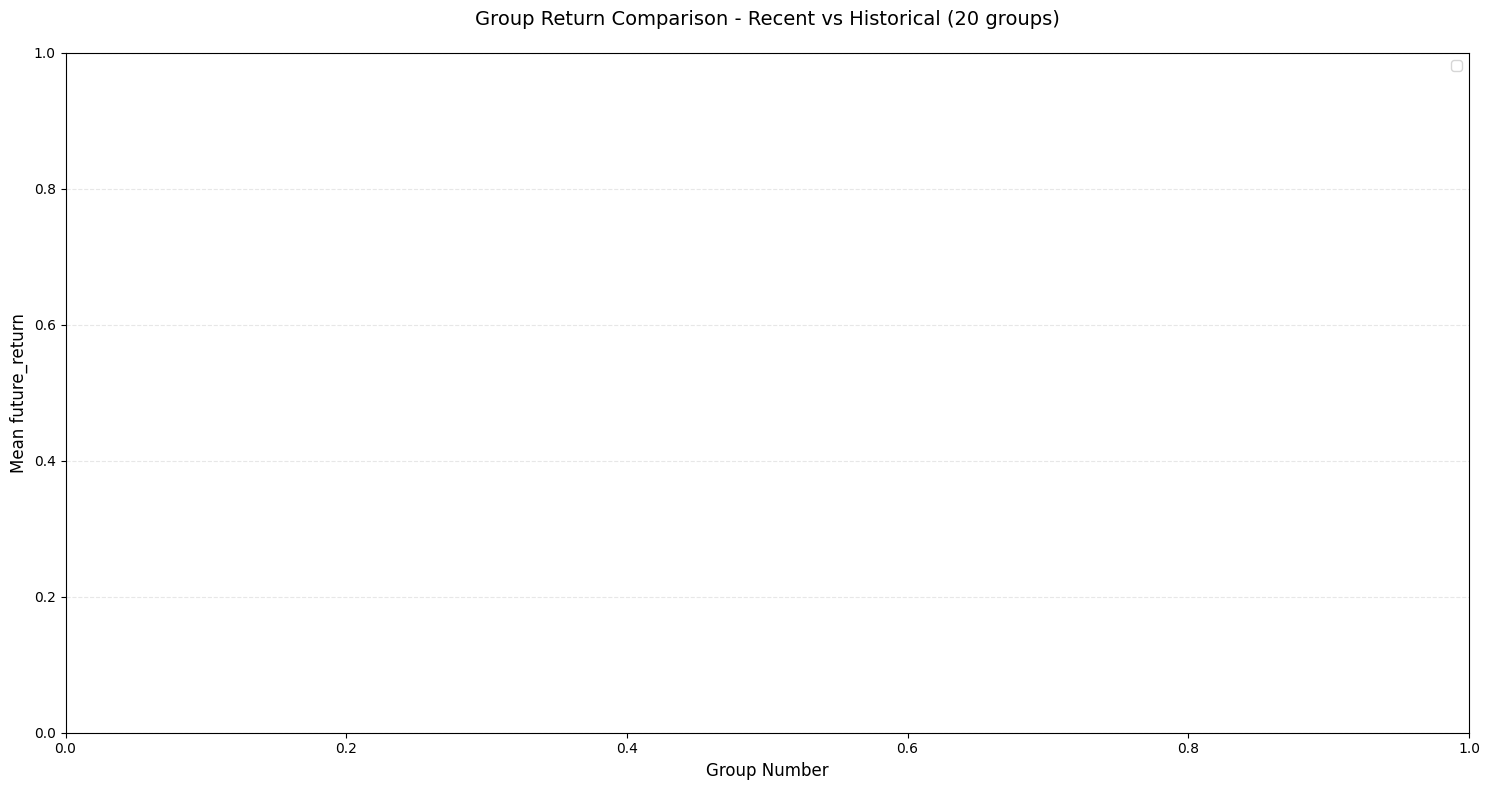

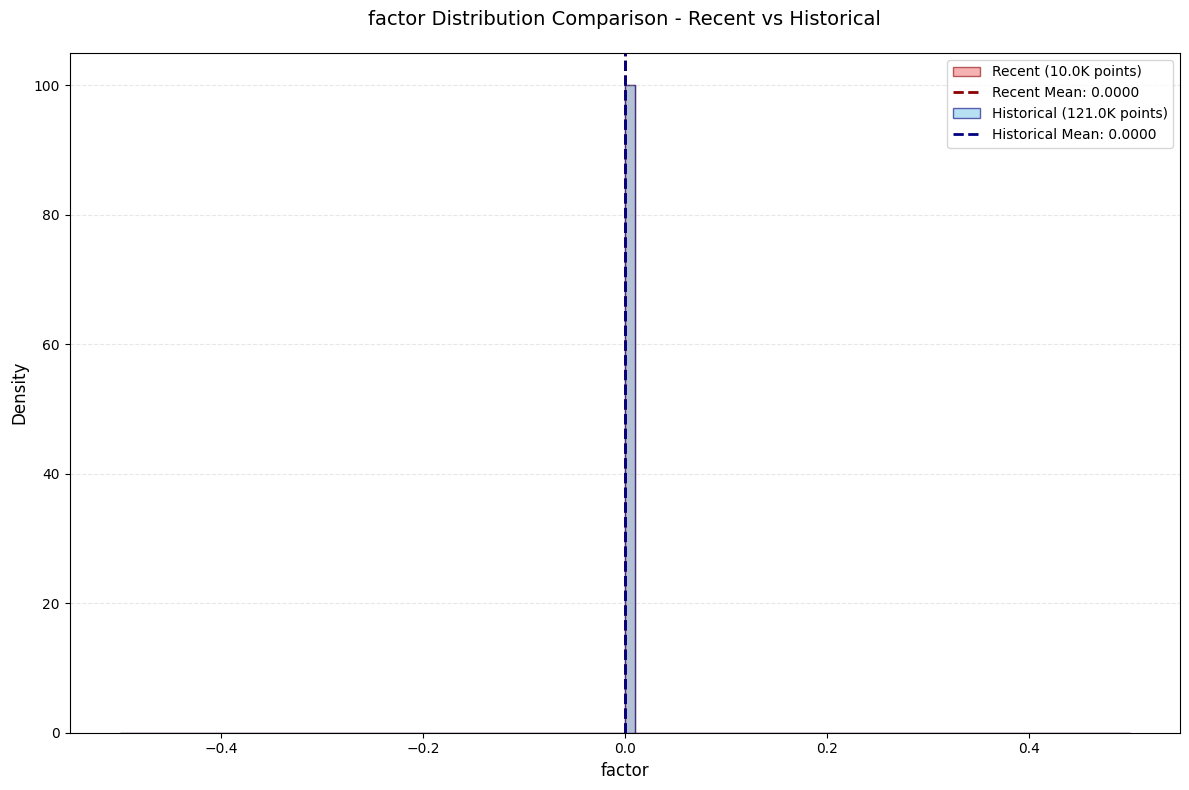

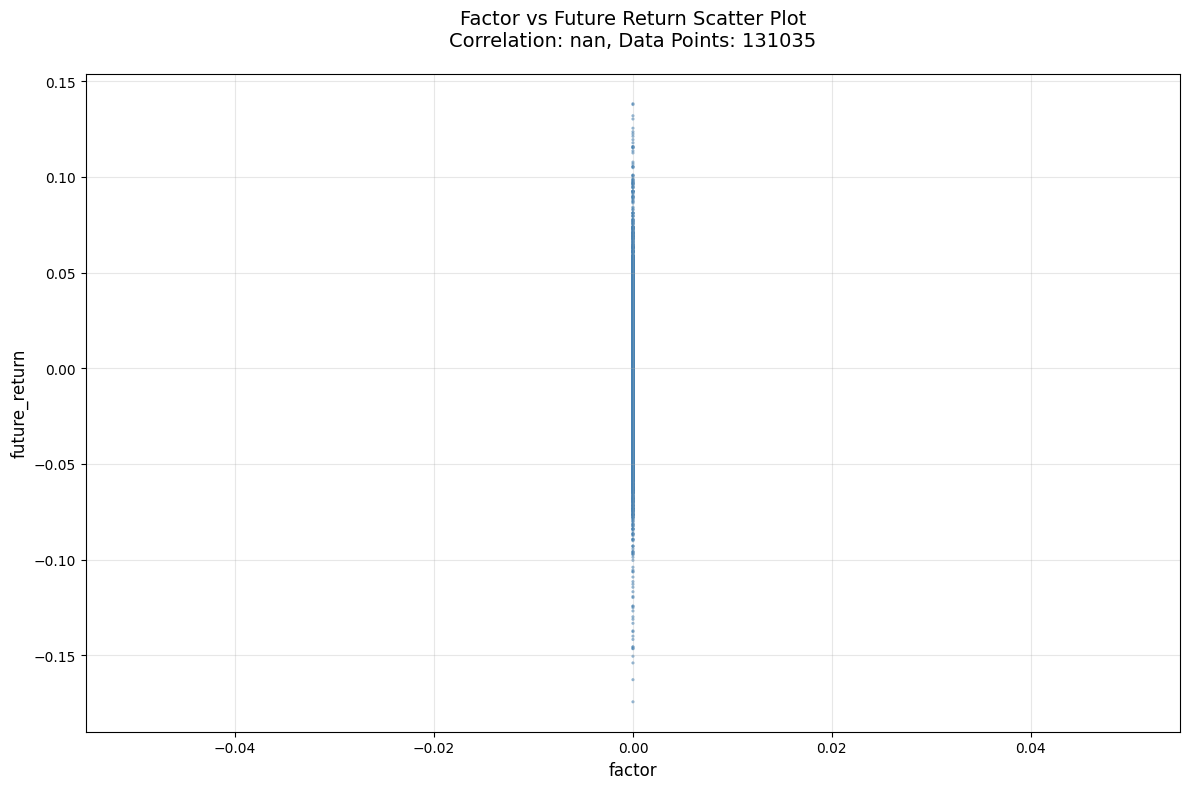

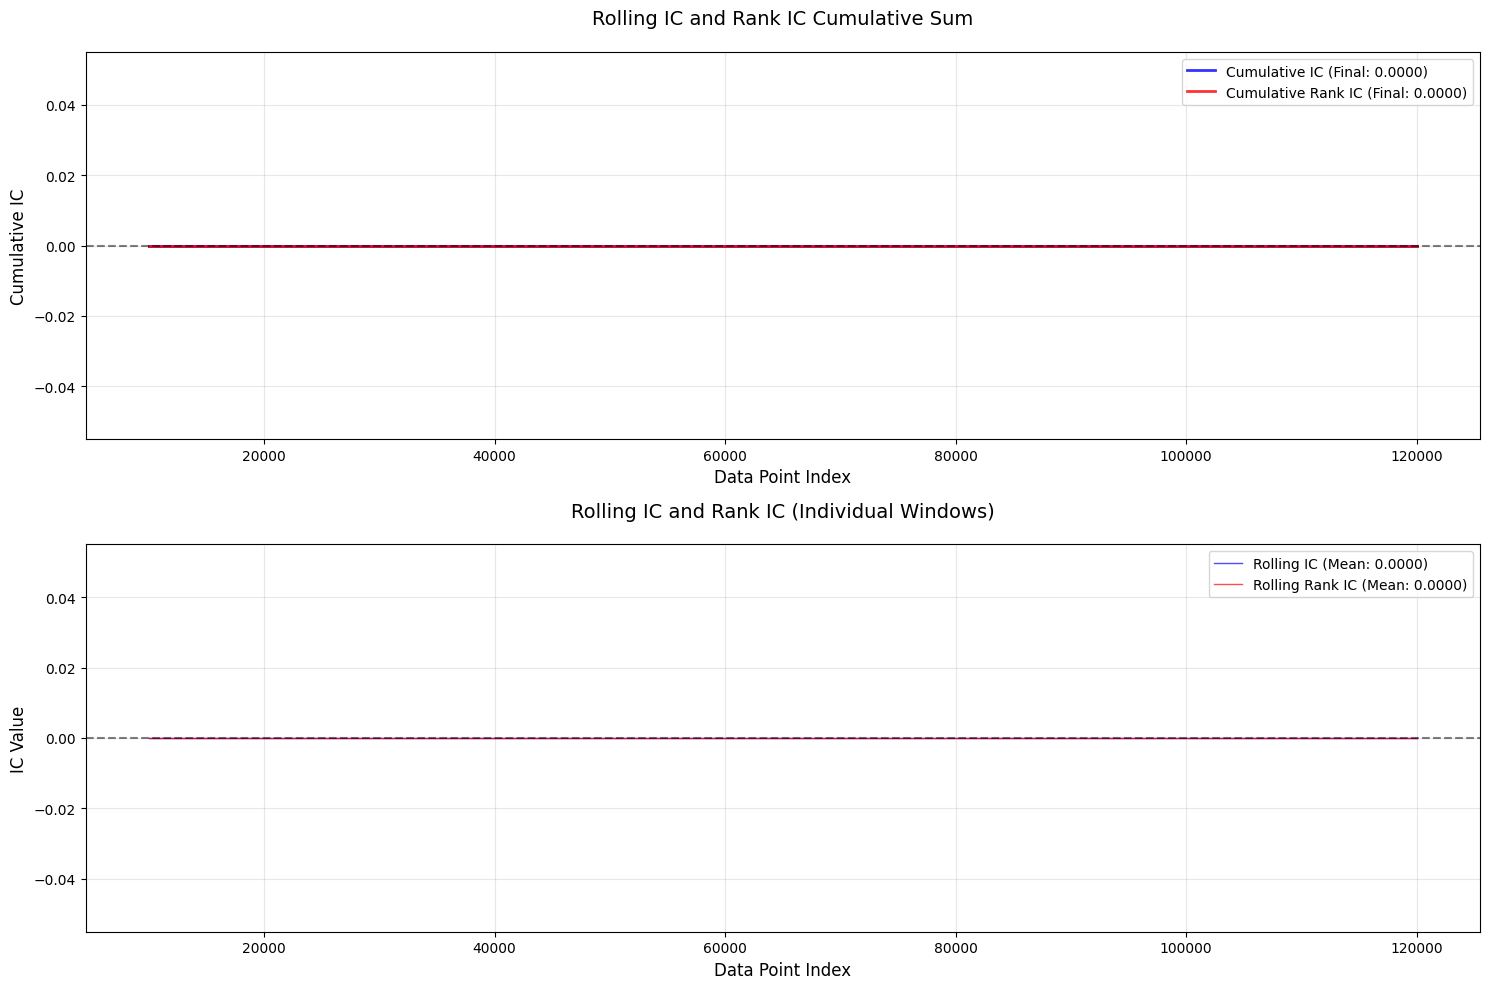

✅ 已显示 4 个图片
----------------------------------------


In [25]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [26]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[]

In [27]:
print(result)

{'correlation_analysis': {'IC': nan, 'Rank_IC': nan}, 'information_ratio': {'IR': nan, 'group_correlations': [], 'n_groups': 0}, 'group_analysis': {'group_stats': Empty DataFrame
Columns: [val_min, val_max, val_mean, return_mean, return_std, count]
Index: [], 'figure': <Figure size 1500x800 with 1 Axes>}, 'factor_distribution': {'descriptive_stats': count   131035.0000
mean         0.0000
std          0.0000
min         -0.0000
1%           0.0000
5%          -0.0000
25%         -0.0000
50%          0.0000
75%         -0.0000
95%          0.0000
99%         -0.0000
max         -0.0000
Name: factor, dtype: float64, 'outlier_analysis': >3std   0.0000
>5std   0.0000
dtype: float64, 'window_stats': {10: {'stats':                                              mean    std  skew  lambda  count
[2021-10-01, 2022-02-14 11:51:00)          0.0000 0.0000     0       0  13104
[2022-02-14 11:51:00, 2022-06-30 23:42:00) 0.0000 0.0000     0       0  13103
[2022-06-30 23:42:00, 2022-11-14 11:33:00) 0.00